In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Layer
from sklearn.preprocessing import StandardScaler
import warnings
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.optimizers import Adam
import keras.backend as K
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.0f}'.format)
import os
import tensorflow as tf
from datetime import datetime

In [2]:
def results(a,b,c,d,e,f,g):
    current_time = datetime.now()
    data = {
        'model' : [g],
        'sim' : [a],
        'mae' : [b],
        'rmse' : [c],
        'fsd' : [d],
        'R' : [e],
        'NSE': [f],
        'time' : [current_time]
    }
    df = pd.DataFrame(data)
    with open('results_combine.csv', 'a', newline='') as f:
        if os.path.isfile('results_combine.csv'):
            df.to_csv('results_combine.csv', mode='a', header=False, index=False)
        else:
            df.to_csv('results_combine.csv', index=False)

def to_df(data_list):
    X_df = [i[:-1] for i in data_list]
    y_df = [i[-1] for i in data_list]
    transposed_lists = [list(x) for x in zip(*X_df)]

    df_list = pd.DataFrame({f'Column{i+1}': lst for i, lst in enumerate(transposed_lists)})
    df_list['Target'] = y_df
    return df_list

def transform_to_multivariate(data, T):
    M = []
    for i in range(len(data) - T):
        row = data[i:i + T + 1]
        M.append(row)
    return np.array(M)

def calculate_similarity(value_lst_after, value_lst_before):
        T = len(value_lst_after)  # Number of missing values
        similarity_sum = 0

        for i in range(T):
            yi = value_lst_after[i]
            xi = value_lst_before[i]
            similarity_sum += 1 / (1 + abs(yi - xi) / (max(value_lst_before) - min(value_lst_before)))

        similarity = similarity_sum / T
        return similarity

def calculate_MAE(value_lst_missing, value_lst_after):
        return mean_absolute_error(value_lst_missing, value_lst_after)

def calculate_RMSE(value_lst_missing, value_lst_after):
    return np.sqrt(mean_squared_error(value_lst_missing, value_lst_after))

def calculate_FB(value_lst_missing, value_lst_after):
    return 2 * abs((np.mean(value_lst_after) - np.mean(value_lst_missing)) / (np.mean(value_lst_after) + np.mean(value_lst_missing)))

def calculate_fsd(value_lst_missing, value_lst_after):
    std_dev_Y = np.std(value_lst_after)
    std_dev_X = np.std(value_lst_missing)

    if std_dev_X == 0:
        return None
    
    fsd = 2 * abs((std_dev_Y - std_dev_X) / (std_dev_X + std_dev_Y))
    
    return fsd

def calculate_r_score(value_lst_missing, value_lst_after):

    correlation_matrix = np.corrcoef(value_lst_missing, value_lst_after)
    r_score = correlation_matrix[0, 1]
    return r_score

def calculate_nse(value_lst_missing, value_lst_after):

    value_lst_missing = np.array(value_lst_missing)
    value_lst_after = np.array(value_lst_after)

    numerator = np.sum((value_lst_missing - value_lst_after)**2)
    denominator = np.sum((value_lst_missing - np.mean(value_lst_missing))**2)

    nse = 1 - (numerator / denominator)
    
    return nse

def calculate_metrics_for_combine(value_lst_after,name_model):
    
    df_before_missing = pd.read_csv('waterlevel.csv')
    value_lst_missing = df_before_missing['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap]


    similarity_score = calculate_similarity(value_lst_after, value_lst_missing)
    MAE_score = calculate_MAE(value_lst_missing, value_lst_after)
    RMSE_score = calculate_RMSE(value_lst_missing, value_lst_after)
    FSD_score = calculate_fsd(value_lst_missing, value_lst_after)
    R_score = calculate_r_score(value_lst_missing, value_lst_after)
    NSE_score = calculate_nse(value_lst_missing, value_lst_after)
    
    sim_lst_combine.append(similarity_score)
    mae_lst_combine.append(MAE_score)
    rmse_lst_combine.append(RMSE_score)
    fsd_lst_combine.append(FSD_score)
    r_lst_combine.append(R_score)
    nse_lst_combine.append(NSE_score)

    
    print('\nOri_data:', value_lst_missing)
    print('\nvalue_data:', value_lst_after)
    print('\nSimilarity_score:', similarity_score)
    print('\nMean Absolute Error (MAE):', MAE_score)
    print('\nRoot Mean Squared Error (RMSE):', RMSE_score)
    print('\nFraction of Standard Deviation Score:', FSD_score)
    print('\nR score:', R_score)
    print('\nThe Nash Sutcliffe efficiency (NSE):', NSE_score)

    results(similarity_score, MAE_score, RMSE_score, FSD_score, R_score, NSE_score,name_model)

def create_continuous_missing_values(dataframe, column_name, num_missing_values):
    modified_df = dataframe.copy()
    
    if len(dataframe) > num_missing_values:
        random_index = random.randint(0, len(dataframe) - num_missing_values)
        modified_df.loc[random_index:random_index + num_missing_values - 1, column_name] = np.nan
    else:
        print("Error: The number of missing values requested exceeds the DataFrame's capacity.")
    return modified_df


sim_lst_combine = []
mae_lst_combine = []
rmse_lst_combine = []
fsd_lst_combine = []
r_lst_combine = []
nse_lst_combine = []

scaler = StandardScaler()

In [3]:
# original_df_path = 'waterlevel.csv'
# try:
#     original_df = pd.read_csv(original_df_path)
    
#     for i in range(0, 12):
#         modified_df = create_continuous_missing_values(original_df, 'Waterlevel', 48)
#         modified_df.to_csv(f'waterlevel_missing_test_{i}.csv', index=False)
        
#         print(f'waterlevel_missing_test_{i}.csv saved with continuous missing values.')

# except FileNotFoundError:
#     print(f"Failed to find '{original_df_path}'. Please check the file path and try again.")

In [4]:
def model_combine(X_train):
    combine = tf.keras.models.Sequential()

    combine.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    combine.add(MaxPooling1D(pool_size=2))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    combine.add(Dropout(0.15))
    
    combine.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    combine.add(Dropout(0.15))

    class Attention(Layer):
        def __init__(self, **kwargs):
            super(Attention, self).__init__(**kwargs)
    
        def build(self, input_shape):
            self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                     initializer='random_normal', trainable=True)
            self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                     initializer='zeros', trainable=True)        
            super(Attention, self).build(input_shape)
     
        def call(self, x):
            e = K.tanh(K.dot(x, self.W) + self.b)
            e = K.squeeze(e, axis=-1)
            alpha = K.softmax(e)
            alpha = K.expand_dims(alpha, axis=-1)
            context = x * alpha
            context = K.sum(context, axis=1)
            return context

    combine.add(Attention())
    
    combine.add(Dense(units=128, activation='relu'))
    
    combine.add(Dense(units=1))
    
    combine.compile(optimizer=Adam(), loss="mean_squared_error", metrics=['mae'])
    
    return combine

### epochs=200, batch_size=16, callbacks (patience=30), validation_split=0.2

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'waterlevel_missing/waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'T:\Python\SU24\AIL\HY\128,256,512,128,128'
        filename = f'128,256,512,128,128, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        folder_path = 'T:\Python\SU24\AIL\HY\128,256,512,128,128'
        filename = f'128,256,512,128,128, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()   
        folder_path = 'T:\Python\SU24\AIL\HY\128,256,512,128,128'
        filename = f'128,256,512,128,128, Missing {location}, epochs=200, batch_size=16, patience=30, validation_split=0.2.png'
        full_path = os.path.join(folder_path, filename)
        plt.savefig(full_path)
        plt.show()
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

Num GPUs Available:  1

All values in df_miss is in the first !!!
Epoch 1/200
3198/3198 [==============================] - 53s 14ms/step - loss: 1317.7848 - mae: 17.5718 - val_loss: 292.3779 - val_mae: 7.6491
Epoch 2/200
3198/3198 [==============================] - 46s 15ms/step - loss: 53.8397 - mae: 5.3862 - val_loss: 258.4455 - val_mae: 7.1592
Epoch 3/200
3198/3198 [==============================] - 41s 13ms/step - loss: 45.1727 - mae: 4.9236 - val_loss: 94.2642 - val_mae: 5.6080
Epoch 4/200
3198/3198 [==============================] - 40s 13ms/step - loss: 39.1770 - mae: 4.5561 - val_loss: 129.0285 - val_mae: 4.4074
Epoch 5/200
3198/3198 [==============================] - 41s 13ms/step - loss: 33.3614 - mae: 4.2254 - val_loss: 94.4892 - val_mae: 4.0892
Epoch 6/200
3198/3198 [==============================] - 41s 13ms/step - loss: 32.4430 - mae: 4.1356 - val_loss: 70.4417 - val_mae: 4.5048
Epoch 7/200
3198/3198 [==============================] - 44s 14ms/step - loss: 32.4658 - mae: 

### epochs=200, batch_size=8, callbacks (patience=30), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()   
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=30, validation_split=0.2.png')
#         plt.show()
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=32, callbacks (patience=30), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, patience=30, validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=8, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=8, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=8, patience=50, validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=16, callbacks (patience=50), validation_split=0.2

Num GPUs Available:  1

All values in df_miss is in the first !!!
Epoch 1/200
3198/3198 [==============================] - 22s 6ms/step - loss: 968.2007 - mae: 15.7415 - val_loss: 199.4818 - val_mae: 7.1795
Epoch 2/200
3198/3198 [==============================] - 20s 6ms/step - loss: 68.8762 - mae: 6.1292 - val_loss: 202.2299 - val_mae: 7.5488
Epoch 3/200
3198/3198 [==============================] - 20s 6ms/step - loss: 58.9985 - mae: 5.5889 - val_loss: 148.6614 - val_mae: 5.4181
Epoch 4/200
3198/3198 [==============================] - 20s 6ms/step - loss: 48.6237 - mae: 5.1464 - val_loss: 200.0724 - val_mae: 6.5497
Epoch 5/200
3198/3198 [==============================] - 20s 6ms/step - loss: 41.7984 - mae: 4.7601 - val_loss: 87.0338 - val_mae: 4.5863
Epoch 6/200
3198/3198 [==============================] - 20s 6ms/step - loss: 38.3780 - mae: 4.5607 - val_loss: 101.8505 - val_mae: 6.2055
Epoch 7/200
3198/3198 [==============================] - 20s 6ms/step - loss: 36.0749 - mae: 4.3828

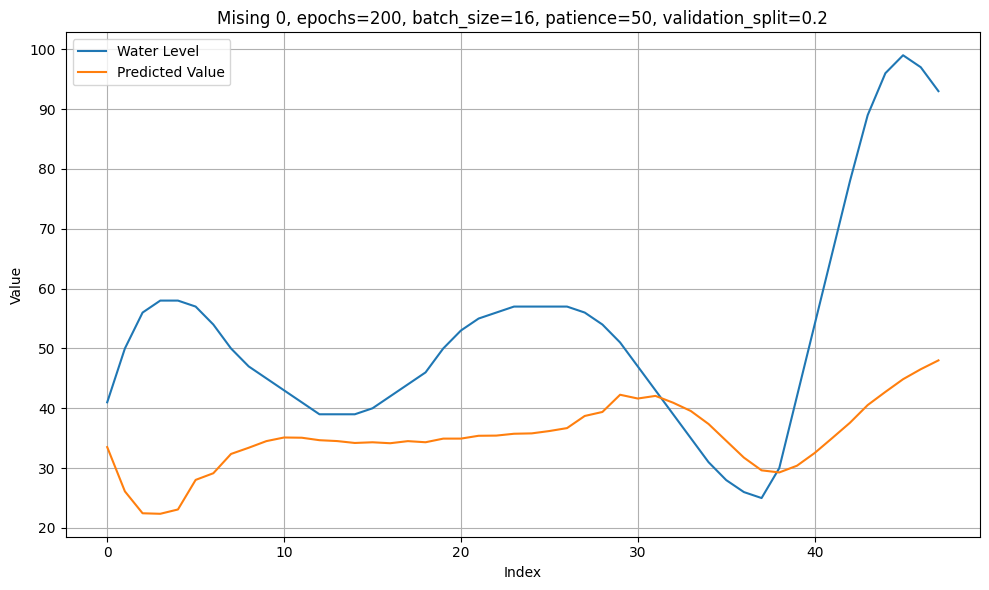


All values in df_miss is in the last !!!
Epoch 1/200
3198/3198 [==============================] - 22s 6ms/step - loss: 1029.5061 - mae: 15.8452 - val_loss: 57.5138 - val_mae: 5.3923
Epoch 2/200
3198/3198 [==============================] - 20s 6ms/step - loss: 90.6909 - mae: 6.9802 - val_loss: 39.6939 - val_mae: 4.7450
Epoch 3/200
3198/3198 [==============================] - 20s 6ms/step - loss: 70.2229 - mae: 6.1102 - val_loss: 25.3064 - val_mae: 3.7234
Epoch 4/200
3198/3198 [==============================] - 20s 6ms/step - loss: 58.9171 - mae: 5.6544 - val_loss: 26.7192 - val_mae: 3.6805
Epoch 5/200
3198/3198 [==============================] - 20s 6ms/step - loss: 53.7374 - mae: 5.3939 - val_loss: 28.3083 - val_mae: 3.8160
Epoch 6/200
3198/3198 [==============================] - 20s 6ms/step - loss: 50.1232 - mae: 5.2195 - val_loss: 21.8484 - val_mae: 3.3804
Epoch 7/200
3198/3198 [==============================] - 20s 6ms/step - loss: 47.3162 - mae: 5.0417 - val_loss: 16.4719 - val_m

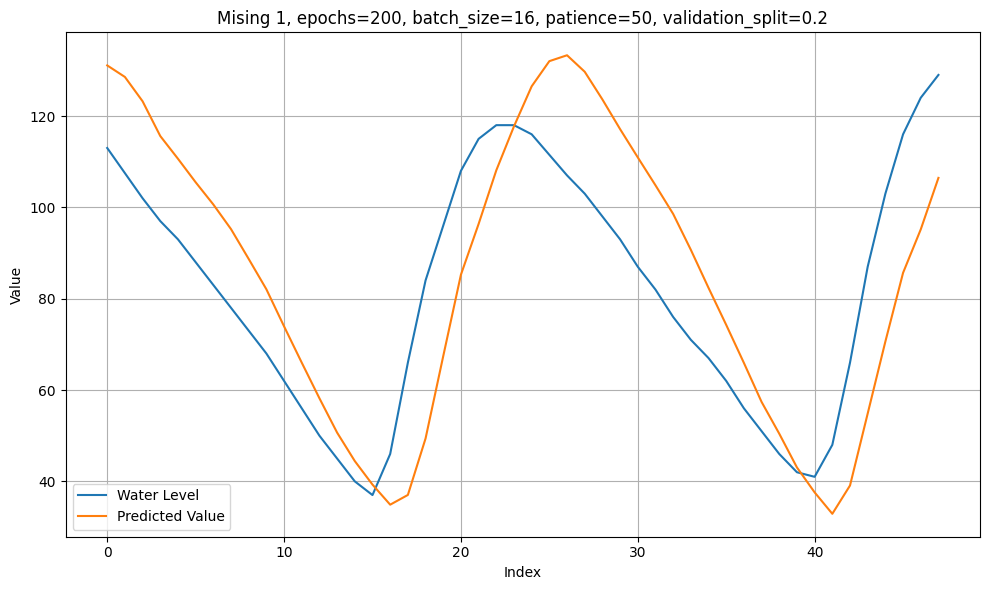

Epoch 1/200
2616/2616 [==============================] - 18s 6ms/step - loss: 716.9936 - mae: 13.9996 - val_loss: 196.1570 - val_mae: 9.1360
Epoch 2/200
2616/2616 [==============================] - 16s 6ms/step - loss: 63.0971 - mae: 5.7947 - val_loss: 26.1576 - val_mae: 3.5213
Epoch 3/200
2616/2616 [==============================] - 16s 6ms/step - loss: 49.2044 - mae: 5.1967 - val_loss: 31.0317 - val_mae: 3.6489
Epoch 4/200
2616/2616 [==============================] - 16s 6ms/step - loss: 42.2695 - mae: 4.7920 - val_loss: 51.9092 - val_mae: 4.2441
Epoch 5/200
2616/2616 [==============================] - 16s 6ms/step - loss: 37.6789 - mae: 4.5603 - val_loss: 30.9423 - val_mae: 3.6112
Epoch 6/200
2616/2616 [==============================] - 16s 6ms/step - loss: 35.3438 - mae: 4.4196 - val_loss: 38.7398 - val_mae: 4.1355
Epoch 7/200
2616/2616 [==============================] - 16s 6ms/step - loss: 33.0463 - mae: 4.2688 - val_loss: 30.2712 - val_mae: 3.2416
Epoch 8/200
2616/2616 [========

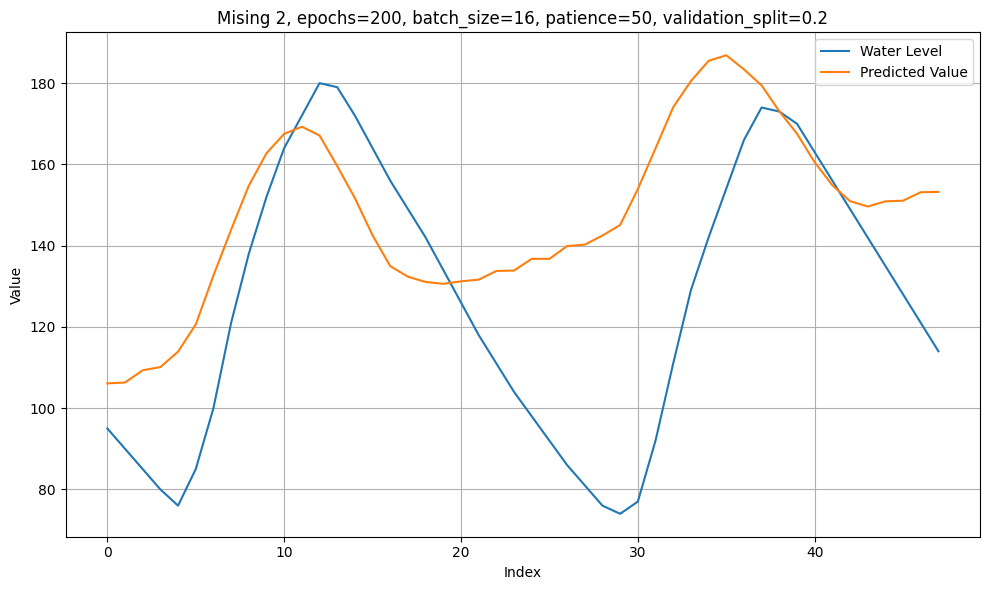

Epoch 1/200
8/8 [==============================] - 2s 61ms/step - loss: 7478.1011 - mae: 84.1908 - val_loss: 8479.5557 - val_mae: 89.0343
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 3669.3171 - mae: 56.0618 - val_loss: 3075.8530 - val_mae: 50.3486
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 757.0196 - mae: 22.9882 - val_loss: 813.9456 - val_mae: 24.7952
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 524.6485 - mae: 18.7594 - val_loss: 545.9096 - val_mae: 20.9453
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 511.5158 - mae: 18.2515 - val_loss: 734.5809 - val_mae: 23.8219
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 380.5330 - mae: 16.3817 - val_loss: 1030.6649 - val_mae: 27.5556
Epoch 7/200
8/8 [==============================] - 0s 8ms/step - loss: 408.5366 - mae: 17.0318 - val_loss: 1016.6368 - val_mae: 27.3911
Epoch 8/200
8/8 [============================

<Figure size 640x480 with 0 Axes>

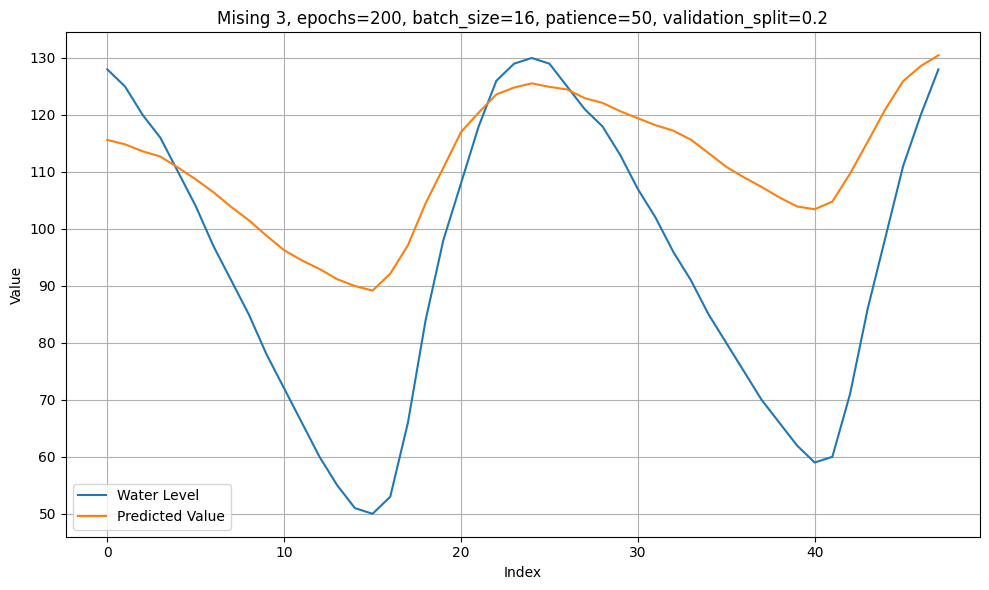

Epoch 1/200
2647/2647 [==============================] - 18s 6ms/step - loss: 983.6112 - mae: 17.2243 - val_loss: 164.0055 - val_mae: 9.3008
Epoch 2/200
2647/2647 [==============================] - 16s 6ms/step - loss: 64.4619 - mae: 5.9301 - val_loss: 44.2025 - val_mae: 4.2028
Epoch 3/200
2647/2647 [==============================] - 16s 6ms/step - loss: 46.1469 - mae: 5.0623 - val_loss: 37.3200 - val_mae: 3.8748
Epoch 4/200
2647/2647 [==============================] - 16s 6ms/step - loss: 42.8600 - mae: 4.8239 - val_loss: 33.0379 - val_mae: 3.5287
Epoch 5/200
2647/2647 [==============================] - 16s 6ms/step - loss: 38.0039 - mae: 4.5309 - val_loss: 26.9472 - val_mae: 3.6963
Epoch 6/200
2647/2647 [==============================] - 16s 6ms/step - loss: 32.5659 - mae: 4.2219 - val_loss: 28.8976 - val_mae: 3.1523
Epoch 7/200
2647/2647 [==============================] - 16s 6ms/step - loss: 30.1372 - mae: 4.0624 - val_loss: 47.4625 - val_mae: 4.4682
Epoch 8/200
2647/2647 [========

<Figure size 640x480 with 0 Axes>

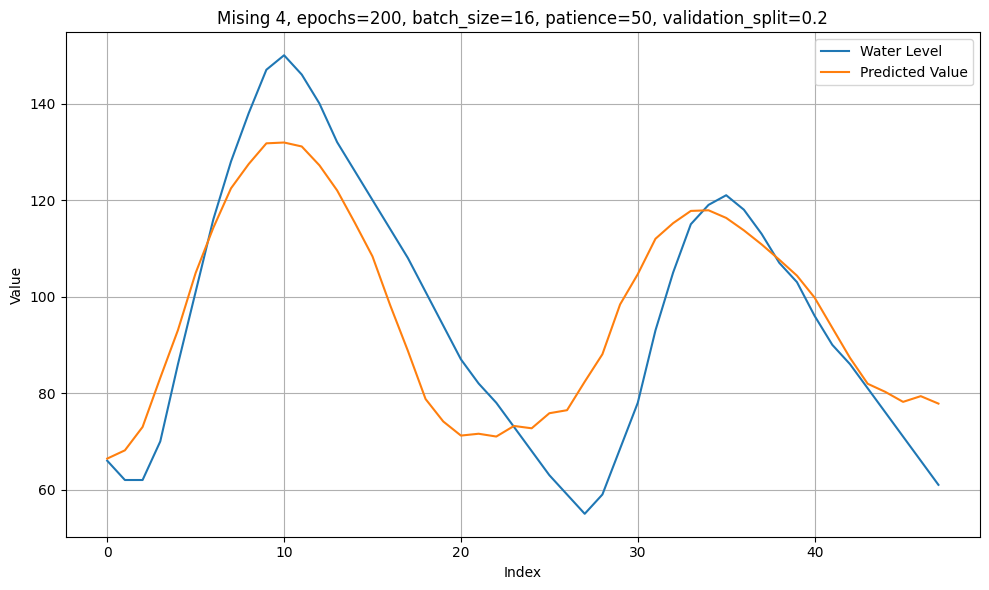

Epoch 1/200
943/943 [==============================] - 8s 7ms/step - loss: 1909.6655 - mae: 27.3332 - val_loss: 74.6812 - val_mae: 6.5551
Epoch 2/200
943/943 [==============================] - 6s 6ms/step - loss: 127.5640 - mae: 8.2269 - val_loss: 80.7074 - val_mae: 7.1386
Epoch 3/200
943/943 [==============================] - 6s 6ms/step - loss: 74.3434 - mae: 6.5041 - val_loss: 44.3767 - val_mae: 5.2020
Epoch 4/200
943/943 [==============================] - 6s 6ms/step - loss: 63.7651 - mae: 5.9380 - val_loss: 28.3781 - val_mae: 3.7677
Epoch 5/200
943/943 [==============================] - 6s 6ms/step - loss: 57.6133 - mae: 5.6843 - val_loss: 41.9739 - val_mae: 4.9996
Epoch 6/200
943/943 [==============================] - 6s 6ms/step - loss: 46.3064 - mae: 5.1519 - val_loss: 18.0391 - val_mae: 3.0181
Epoch 7/200
943/943 [==============================] - 6s 6ms/step - loss: 48.5129 - mae: 5.2075 - val_loss: 18.2126 - val_mae: 3.2884
Epoch 8/200
943/943 [==============================

<Figure size 640x480 with 0 Axes>

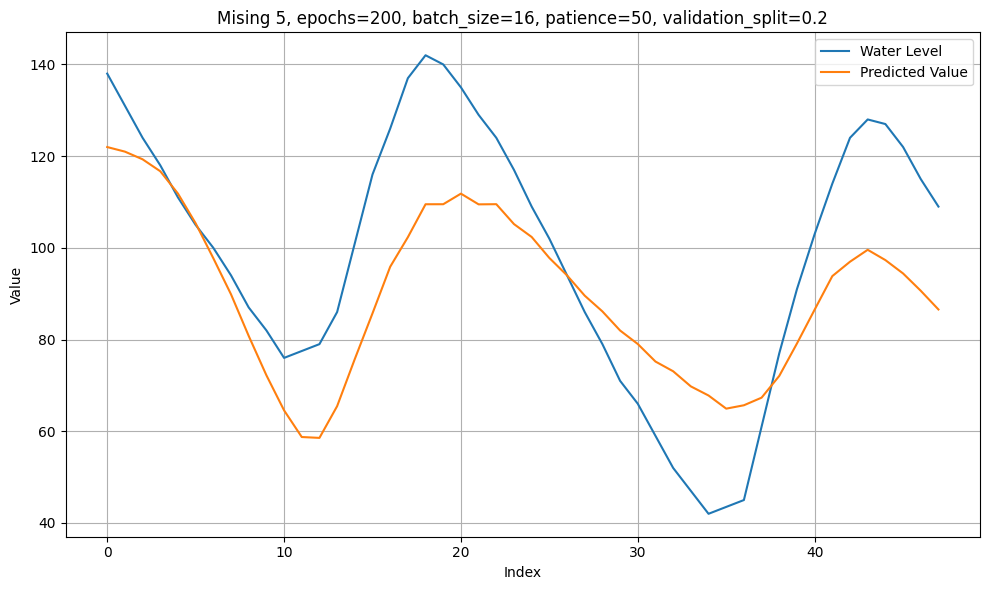

Epoch 1/200
826/826 [==============================] - 7s 6ms/step - loss: 2520.2063 - mae: 36.8072 - val_loss: 1680.8624 - val_mae: 23.2238
Epoch 2/200
826/826 [==============================] - 5s 6ms/step - loss: 103.0784 - mae: 7.3687 - val_loss: 336.0226 - val_mae: 9.8198
Epoch 3/200
826/826 [==============================] - 5s 6ms/step - loss: 61.1389 - mae: 5.8899 - val_loss: 225.9000 - val_mae: 8.0750
Epoch 4/200
826/826 [==============================] - 5s 6ms/step - loss: 47.8880 - mae: 5.2878 - val_loss: 183.2244 - val_mae: 6.7360
Epoch 5/200
826/826 [==============================] - 5s 6ms/step - loss: 44.3653 - mae: 5.0469 - val_loss: 549.1536 - val_mae: 13.6590
Epoch 6/200
826/826 [==============================] - 5s 6ms/step - loss: 40.6839 - mae: 4.8371 - val_loss: 120.5669 - val_mae: 5.9704
Epoch 7/200
826/826 [==============================] - 5s 6ms/step - loss: 40.4113 - mae: 4.8024 - val_loss: 162.1372 - val_mae: 6.6380
Epoch 8/200
826/826 [====================

<Figure size 640x480 with 0 Axes>

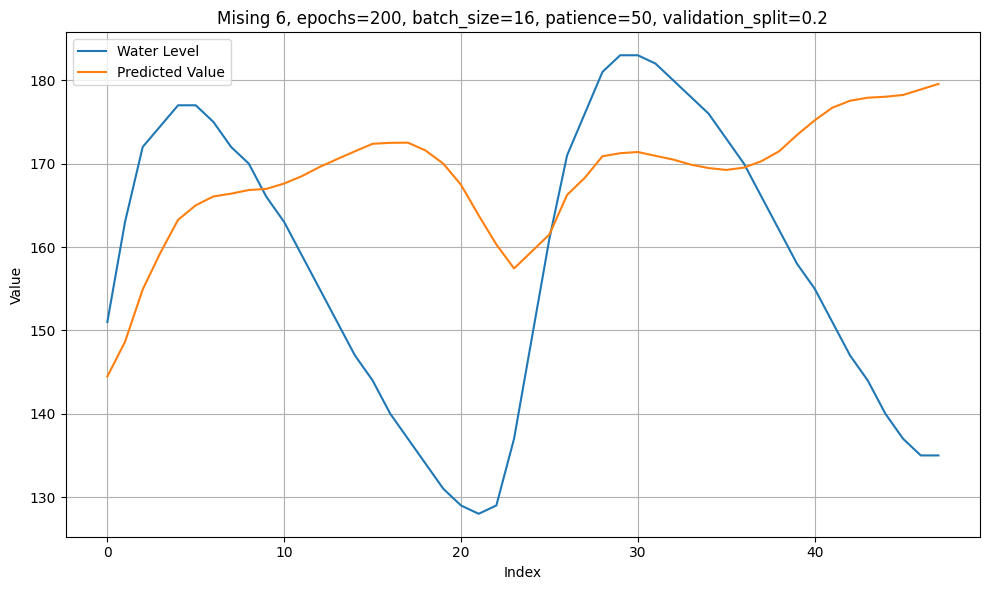

Epoch 1/200
1558/1558 [==============================] - 22s 12ms/step - loss: 1537.2915 - mae: 22.5118 - val_loss: 61.3039 - val_mae: 6.1814
Epoch 2/200
1558/1558 [==============================] - 18s 12ms/step - loss: 110.9773 - mae: 7.8328 - val_loss: 31.0440 - val_mae: 4.3834
Epoch 3/200
1558/1558 [==============================] - 18s 12ms/step - loss: 75.9289 - mae: 6.5263 - val_loss: 27.7535 - val_mae: 4.2914
Epoch 4/200
1558/1558 [==============================] - 19s 12ms/step - loss: 65.1254 - mae: 5.9615 - val_loss: 24.4483 - val_mae: 3.6732
Epoch 5/200
1558/1558 [==============================] - 19s 12ms/step - loss: 63.2896 - mae: 5.8109 - val_loss: 22.9360 - val_mae: 3.6230
Epoch 6/200
1558/1558 [==============================] - 18s 12ms/step - loss: 52.7471 - mae: 5.4039 - val_loss: 14.9371 - val_mae: 2.9250
Epoch 7/200
1558/1558 [==============================] - 19s 12ms/step - loss: 46.5144 - mae: 5.1321 - val_loss: 21.9147 - val_mae: 3.6829
Epoch 8/200
1558/1558 [

<Figure size 640x480 with 0 Axes>

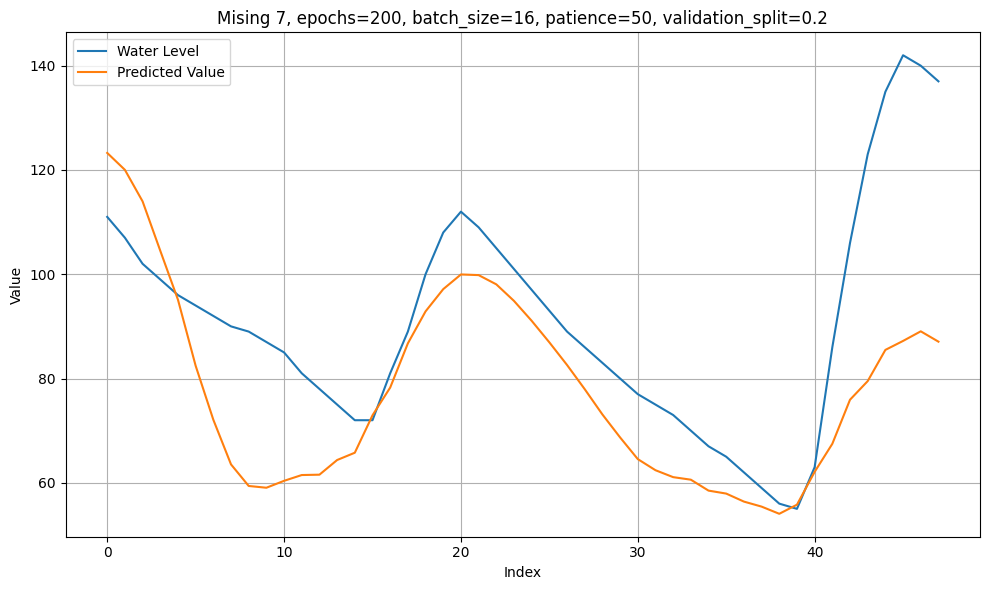

Epoch 1/200
2751/2751 [==============================] - 20s 7ms/step - loss: 1062.0245 - mae: 16.4216 - val_loss: 82.0653 - val_mae: 5.4144
Epoch 2/200
2751/2751 [==============================] - 18s 6ms/step - loss: 55.3715 - mae: 5.5227 - val_loss: 145.0185 - val_mae: 10.1845
Epoch 3/200
2751/2751 [==============================] - 18s 6ms/step - loss: 46.1255 - mae: 5.0295 - val_loss: 43.4936 - val_mae: 5.0690
Epoch 4/200
2751/2751 [==============================] - 18s 6ms/step - loss: 39.9494 - mae: 4.6647 - val_loss: 28.8460 - val_mae: 3.7380
Epoch 5/200
2751/2751 [==============================] - 18s 7ms/step - loss: 34.2197 - mae: 4.3422 - val_loss: 52.0358 - val_mae: 5.7018
Epoch 6/200
2751/2751 [==============================] - 18s 7ms/step - loss: 32.7457 - mae: 4.1949 - val_loss: 28.2271 - val_mae: 3.4690
Epoch 7/200
2751/2751 [==============================] - 18s 7ms/step - loss: 32.5088 - mae: 4.1529 - val_loss: 74.4328 - val_mae: 4.4083
Epoch 8/200
2751/2751 [======

<Figure size 640x480 with 0 Axes>

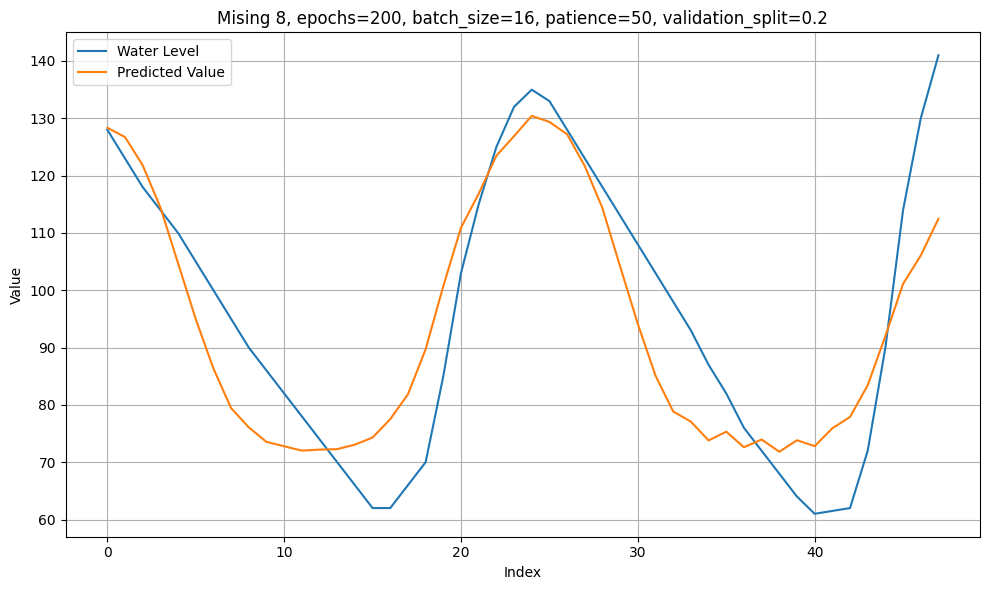

Epoch 1/200
146/146 [==============================] - 3s 9ms/step - loss: 1784.9385 - mae: 33.7895 - val_loss: 1344.3975 - val_mae: 30.8197
Epoch 2/200
146/146 [==============================] - 1s 7ms/step - loss: 1138.7894 - mae: 27.5706 - val_loss: 817.4220 - val_mae: 23.5814
Epoch 3/200
146/146 [==============================] - 1s 7ms/step - loss: 383.4022 - mae: 15.2933 - val_loss: 207.8321 - val_mae: 11.5870
Epoch 4/200
146/146 [==============================] - 1s 7ms/step - loss: 121.2731 - mae: 8.5340 - val_loss: 111.0328 - val_mae: 8.5635
Epoch 5/200
146/146 [==============================] - 1s 8ms/step - loss: 67.3880 - mae: 6.3948 - val_loss: 53.5656 - val_mae: 5.9290
Epoch 6/200
146/146 [==============================] - 1s 8ms/step - loss: 44.5333 - mae: 5.2175 - val_loss: 45.8527 - val_mae: 5.5765
Epoch 7/200
146/146 [==============================] - 1s 7ms/step - loss: 40.9990 - mae: 4.9644 - val_loss: 46.6191 - val_mae: 5.4268
Epoch 8/200
146/146 [=================

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


for location in range(0,12):
    
    filename = f'waterlevel_missing_{location}.csv'
    df = pd.read_csv(filename)
    
    #### Check size of missing value
    size_of_gap = df['Waterlevel'].isna().sum()

    data = df['Waterlevel'].values.tolist()

    nan_index = None
    for j, value in enumerate(data):
        if value != value:  # Check if the value is NaN
            nan_index = j
            break
        
    df_check_before = data[:(3*size_of_gap)+1]
    df_check_after = data[::-1][:3*size_of_gap+1]
    df_miss = data[nan_index:nan_index + size_of_gap]

    last_data = data[:nan_index]
    first_data = data[nan_index+size_of_gap:][::-1]

    # check if missing values is in the first 3 x T data original
    if all(value in df_check_before for value in df_miss):
        print('\nAll values in df_miss is in the first !!!')

        first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
        df_list = to_df(first_value_combine)
        

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
        data_test = np.concatenate(data_test).ravel()   

        results_first_combine = []
        for i in range(len(data_test)//2):
            data_first = data_test[i:i+1+size_of_gap]

            data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

            results_first_combine.append(data_first[size_of_gap])
            
        ###################################################################
        print('\n', 'result of combine only (first):')                        #  
        calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
        print('\n')                                                       #
        ###################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'64,128,256,200,200, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png')
        plt.show()
        
    elif all(value in df_check_after for value in df_miss):
        print('\nAll values in df_miss is in the last !!!')
        
        last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
        df_list = to_df(last_value_combine)

        X = np.array(df_list.iloc[:, :-1])
        X = scaler.fit_transform(X)
        
        y = np.array(df_list.iloc[:, -1])
        
        model = model_combine(X)
        model.fit(X, y, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test = np.concatenate(data_test).ravel()   

        results_last_combine = []
        for i in range(len(data_test)//2):
            data_last = data_test[i:i+1+size_of_gap]

            data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

            results_last_combine.append(data_last[size_of_gap])
            
        #################################################################
        print('\n', 'result of combine only (last):')                       #
        calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
        print('\n')                                                     #
        # #################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'64,128,256,200,200, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png')
        plt.show()
        
    else:
        Da = data[nan_index + size_of_gap:][::-1]

        MDa = transform_to_multivariate(Da, size_of_gap)

        df_MDa = to_df(MDa)

        X_MDa_train = np.array(df_MDa.iloc[:, :-1])
        X_MDa_train = scaler.fit_transform(X_MDa_train)
        
        y_MDa_train = np.array(df_MDa.iloc[:, -1])

        model_MDa = model_combine(X_MDa_train)
        model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)
        
        data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
        data_test_after = np.concatenate(data_test_after).ravel()   

        value_lst_after = []
        for j in range(len(data_test_after)//2):
            data_after = data_test_after[j:j+1+size_of_gap]
            
            data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
            value_lst_after.append(data_after[size_of_gap])

        Db = data[:nan_index]

        MDb = transform_to_multivariate(Db, size_of_gap)  

        df_MDb = to_df(MDb)

        X_MDb_train = np.array(df_MDb.iloc[:, :-1])
        X_MDb_train = scaler.fit_transform(X_MDb_train)
        
        y_MDb_train = np.array(df_MDb.iloc[:, -1])

        model_MDb = model_combine(X_MDb_train)
        model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=16, callbacks=[early_stopping], validation_split=0.2)

        data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
        data_test_before = np.concatenate(data_test_before).ravel()   

        value_lst_before = []
        for i in range(len(data_test_before)//2):
            data_before = data_test_before[i:i+1+size_of_gap]
            
            data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

            value_lst_before.append(data_before[size_of_gap])

        #############################################################################
        print('\n', 'result of combine only: ')                                         #
        results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
        calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
        print('\n')                                                                 #
        #############################################################################
        
        df = pd.read_csv('Impute_misvalues_hungyen.csv')

        plt.figure(figsize=(10, 6))
        plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
        plt.plot(results_combine, label='Predicted Value', linestyle='-')
        plt.title(f'Mising {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()    
        plt.savefig(f'64,128,256,200,200, Missing {location}, epochs=200, batch_size=16, patience=50, validation_split=0.2.png')
    
    
current_time = datetime.now()

print('\n')
print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
print('\nMean of R-score combine: ', np.mean(r_lst_combine))
print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
print('\n')

### epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=32, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=64, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=128, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=128, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')

### epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # tf.debugging.set_log_device_placement(True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# for location in range(0,12):
    
#     filename = f'waterlevel_missing_{location}.csv'
#     df = pd.read_csv(filename)
    
#     #### Check size of missing value
#     size_of_gap = df['Waterlevel'].isna().sum()

#     data = df['Waterlevel'].values.tolist()

#     nan_index = None
#     for j, value in enumerate(data):
#         if value != value:  # Check if the value is NaN
#             nan_index = j
#             break
        
#     df_check_before = data[:(3*size_of_gap)+1]
#     df_check_after = data[::-1][:3*size_of_gap+1]
#     df_miss = data[nan_index:nan_index + size_of_gap]

#     last_data = data[:nan_index]
#     first_data = data[nan_index+size_of_gap:][::-1]

#     # check if missing values is in the first 3 x T data original
#     if all(value in df_check_before for value in df_miss):
#         print('\nAll values in df_miss is in the first !!!')

#         first_value_combine = transform_to_multivariate(first_data, size_of_gap)
                
#         df_list = to_df(first_value_combine)
        

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index : nan_index + 2 * size_of_gap][::-1]
#         data_test = np.concatenate(data_test).ravel()   

#         results_first_combine = []
#         for i in range(len(data_test)//2):
#             data_first = data_test[i:i+1+size_of_gap]

#             data_first[size_of_gap] = model.predict(scaler.transform(np.array(data_first[:size_of_gap]).reshape(1,-1)))

#             results_first_combine.append(data_first[size_of_gap])
            
#         ###################################################################
#         print('\n', 'result of combine only (first):')                        #  
#         calculate_metrics_for_combine(results_first_combine,'results_combine (FIRST)')#
#         print('\n')                                                       #
#         ###################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_first_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     elif all(value in df_check_after for value in df_miss):
#         print('\nAll values in df_miss is in the last !!!')
        
#         last_value_combine = transform_to_multivariate(last_data, size_of_gap)
                
#         df_list = to_df(last_value_combine)

#         X = np.array(df_list.iloc[:, :-1])
#         X = scaler.fit_transform(X)
        
#         y = np.array(df_list.iloc[:, -1])
        
#         model = model_combine(X)
#         model.fit(X, y, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test = np.concatenate(data_test).ravel()   

#         results_last_combine = []
#         for i in range(len(data_test)//2):
#             data_last = data_test[i:i+1+size_of_gap]

#             data_last[size_of_gap] = model.predict(scaler.transform(np.array(data_last[:size_of_gap]).reshape(1,-1)))

#             results_last_combine.append(data_last[size_of_gap])
            
#         #################################################################
#         print('\n', 'result of combine only (last):')                       #
#         calculate_metrics_for_combine(results_last_combine,'results_combine (LAST)')#
#         print('\n')                                                     #
#         # #################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_last_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
#         plt.show()
        
#     else:
#         Da = data[nan_index + size_of_gap:][::-1]

#         MDa = transform_to_multivariate(Da, size_of_gap)

#         df_MDa = to_df(MDa)

#         X_MDa_train = np.array(df_MDa.iloc[:, :-1])
#         X_MDa_train = scaler.fit_transform(X_MDa_train)
        
#         y_MDa_train = np.array(df_MDa.iloc[:, -1])

#         model_MDa = model_combine(X_MDa_train)
#         model_MDa.fit(X_MDa_train, y_MDa_train, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)
        
#         data_test_after = df.values.tolist()[nan_index:nan_index + 2 * size_of_gap ][::-1]
#         data_test_after = np.concatenate(data_test_after).ravel()   

#         value_lst_after = []
#         for j in range(len(data_test_after)//2):
#             data_after = data_test_after[j:j+1+size_of_gap]
            
#             data_after[size_of_gap] = model_MDa.predict(scaler.transform(np.array(data_after[:size_of_gap]).reshape(1,-1)))
            
#             value_lst_after.append(data_after[size_of_gap])

#         Db = data[:nan_index]

#         MDb = transform_to_multivariate(Db, size_of_gap)  

#         df_MDb = to_df(MDb)

#         X_MDb_train = np.array(df_MDb.iloc[:, :-1])
#         X_MDb_train = scaler.fit_transform(X_MDb_train)
        
#         y_MDb_train = np.array(df_MDb.iloc[:, -1])

#         model_MDb = model_combine(X_MDb_train)
#         model_MDb.fit(X_MDb_train, y_MDb_train, epochs=200, batch_size=256, callbacks=[early_stopping], validation_split=0.2)

#         data_test_before = df.values.tolist()[nan_index - size_of_gap : nan_index + size_of_gap]
#         data_test_before = np.concatenate(data_test_before).ravel()   

#         value_lst_before = []
#         for i in range(len(data_test_before)//2):
#             data_before = data_test_before[i:i+1+size_of_gap]
            
#             data_before[size_of_gap] = model_MDb.predict(scaler.transform(np.array(data_before[:size_of_gap]).reshape(1,-1)))

#             value_lst_before.append(data_before[size_of_gap])

#         #############################################################################
#         print('\n', 'result of combine only: ')                                         #
#         results_combine =  [(x + y)/2 for x,y in zip(value_lst_before, value_lst_after)]#
#         calculate_metrics_for_combine(results_combine,'results_combine (MIDDLE)')               #
#         print('\n')                                                                 #
#         #############################################################################
        
#         df = pd.read_csv('Impute_misvalues_hungyen.csv')

#         plt.figure(figsize=(10, 6))
#         plt.plot(df['Waterlevel'].values.tolist()[nan_index:nan_index+size_of_gap], label='Water Level')
#         plt.plot(results_combine, label='Predicted Value', linestyle='-')
#         plt.title(f'Water Level vs Predicted Value, mising {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()    
#         plt.savefig(f'Missing {location}, epochs=200, batch_size=256, callbacks (patience=50), validation_split=0.2.png')
    
    
# current_time = datetime.now()

# print('\n')
# print('\nMean of Similarity combine: ',np.mean(sim_lst_combine))
# print('\nMean of Mean Absoulute Error combine :',np.mean(mae_lst_combine))
# print('\nMean of Root Mean Squared Error combine: ',np.mean(rmse_lst_combine))
# print('\nMean of Fraction of Standard Deviation combine: ',np.mean(fsd_lst_combine)) 
# print('\nMean of R-score combine: ', np.mean(r_lst_combine))
# print('\nMean of the Nash Sutcliffe efficiency (NSE): ', np.mean(nse_lst_combine))
# print('\n')